# Exploratory Data Analysis - Billboard Hot 100 & Spotify Track Data

## 1.0 Import Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
#billboard chart data
charts = pd.read_csv('../data/raw/chart-data', index_col=0)
#unique songs
songs = pd.read_csv('../data/raw/unique-songs', index_col=0)
#songs matched incorrectly
error_matches = pd.read_csv('../data/raw/incorrect-matches.csv')

### 1.1 Billboard Chart Data

In [3]:
charts['Date'] =  pd.to_datetime(charts['Date'], format='%Y-%m-%d')
charts.head()

,Rank,Date,BB_Title,BB_Artist,PeakPos,LastPos,Weeks
0,1,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,1,6
1,2,2021-08-28,Bad Habits,Ed Sheeran,2,3,8
2,3,2021-08-28,Good 4 U,Olivia Rodrigo,1,2,14
3,4,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,0,1
4,5,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,4,19


### 1.2 Unique Song Data

In [4]:
old_size = songs.shape

In [5]:
error_matches.drop(columns='Match_Ratio').head()

,BB_Title,BB_Artist,SP_Title,SP_Artist,SP_id
0,Skate,Silk Sonic (Bruno Mars & Anderson .Paak),Infrared Skateboard,Star Silk,4wi3PCbi1XRT07SuaBNhv7
1,Hellcats & Trackhawks,Lil Durk,Hellcats & Trackhawks,LilRonnie FYG,3641Vdge9brzX9EneSPVZM
2,On The Ground,ROSE,Feet on the Ground,Pernille Rosendahl,4AuFQsunFnXzZ4Hh0Syf1p
3,Reminds Me Of You,The Kid LAROI & Juice WRLD,He Reminds Me Of You,The High Plains Drifters,0lVenYsMaCx2o7RwziTn1h
4,Don't Stop,Megan Thee Stallion Featuring Young Thug,Don't Stop Now,Megan Anourissa,5U3GVNt91eh9jfCNWEnwnz


In [6]:
#remove poor matches, blank sp_id and duplicated sp_id
songs['Date'] =  pd.to_datetime(songs['Date'], format='%Y-%m-%d')

#move songs with an incorrect match
songs = songs[(~songs.SP_id.isin(error_matches.SP_id)) & (songs.Match_Ratio > 60)]\
                            .dropna(axis=0, subset=['SP_id']).drop_duplicates(subset='SP_id',keep=False)\
                            .reset_index(drop = True)

#drop unnecessary columns
songs.drop(columns=['Rank','LastPos','Match_Ratio'], inplace=True)

#change number value of key to specific keys
songs['key'] = songs['key'].map({0.0: 'C', 1.0: 'C#, Db', 2.0: 'D',\
                                3.0: 'D#, Eb', 4.0: 'E', 5.0: 'F',\
                                6.0: 'F#, Gb', 7.0: 'G', 8.0: 'G#, Ab',\
                                9.0: 'A', 10.0: 'A#, Bb', 11.0: 'B'})
#change number value of mode to major/minor
songs['mode'] = songs['mode'].map({0.0: 'Minor', 1.0: 'Major'})

songs.head()

,Date,BB_Title,BB_Artist,PeakPos,Weeks,SP_Title,SP_Artist,SP_id,Genres,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2021-08-28,Stay,The Kid LAROI & Justin Bieber,1,6,STAY (with Justin Bieber),The Kid LAROI,5HCyWlXZPP0y6Gqq8TgA20,australian hip hop,0.591,...,-5.484,Major,0.0483,0.0383,0.000000,0.1030,0.478,169.928,141806.0,4.0
1,2021-08-28,Bad Habits,Ed Sheeran,2,8,Bad Habits,Ed Sheeran,6PQ88X9TkUIAUIZJHW2upE,"pop,uk pop",0.808,...,-3.712,Minor,0.0348,0.0469,0.000031,0.3640,0.591,126.026,231041.0,4.0
2,2021-08-28,Good 4 U,Olivia Rodrigo,1,14,good 4 u,Olivia Rodrigo,4ZtFanR9U6ndgddUvNcjcG,pop,0.563,...,-5.044,Major,0.1540,0.3350,0.000000,0.0849,0.688,166.928,178147.0,4.0
3,2021-08-28,Rumors,Lizzo Featuring Cardi B,4,1,Rumors (feat. Cardi B),Lizzo,6KgtcmCF9Ky68XC7ezxl3s,"dance pop,escape room,minnesota hip hop,pop,tr...",0.827,...,-5.524,Minor,0.0880,0.1300,0.000000,0.4180,0.607,118.992,172833.0,4.0
4,2021-08-28,Kiss Me More,Doja Cat Featuring SZA,3,19,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,"dance pop,pop",0.762,...,-3.541,Major,0.0286,0.2350,0.000158,0.1230,0.742,110.968,208867.0,4.0


In [7]:
new_size = songs.shape

old_size, new_size

#lost 4.8%% of unique songs due to error, 223 total

((4832, 25), (4609, 22))

## 2.0 Billboard Chart EDA

In [8]:
by_year = charts.groupby(by=charts['Date'].dt.year).mean()

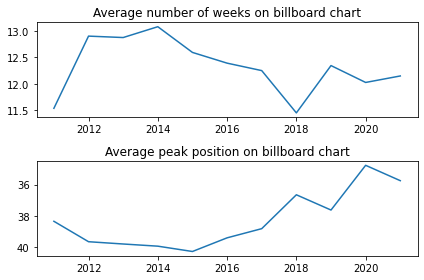

In [9]:
#review year over year trends for average longevity and peak position on charts
fig, ax = plt.subplots(2)

ax[0].plot(by_year.index.values, by_year['Weeks'])
ax[1].plot(by_year.index.values, by_year['PeakPos'])

ax[0].set_title('Average number of weeks on billboard chart')
ax[1].set_title('Average peak position on billboard chart')


fig.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 3.0 Unique Song Data EDA

In [10]:
#this function will be used throughout this section for building the scatterplot grids
def scatterplots(columns, y, data, feature_key=[], invert=False, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        if invert == True:
            ax.invert_yaxis()
        ax.scatter(x = col, y = y, data=data, alpha=0.5)
        if col in feature_key:
            ax.set_xlim([0,1])
        ax.set(xlabel=col, ylabel=y)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

### 3.1 Explore Each Song Individually

In [11]:
#all numerical features - PeakPos & Weeks are target features
features = ['PeakPos', 'Weeks', 'danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms', 'time_signature']
#features scored from 0 to 1
zero_to_one_features = [x for x in features if x not in ['PeakPos','Weeks','loudness',\
                                                         'tempo','duration_ms','time_signature']]

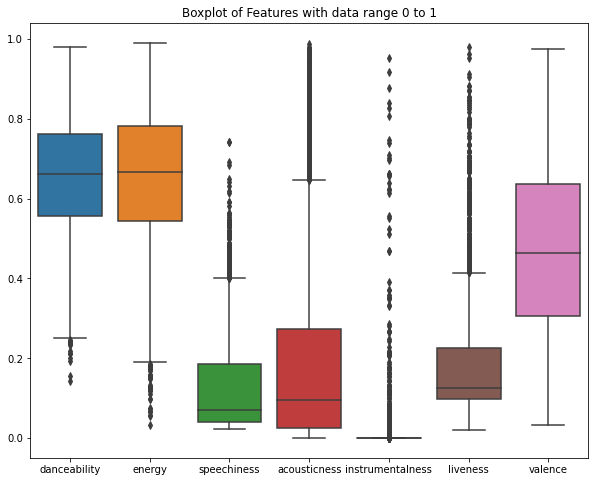

In [12]:
#boxplot for features on the same scoring scale - 0 to 1
plt.subplots(figsize=(10,8))
sns.boxplot(data=songs[zero_to_one_features])
plt.title('Boxplot of Features with data range 0 to 1')
plt.show()

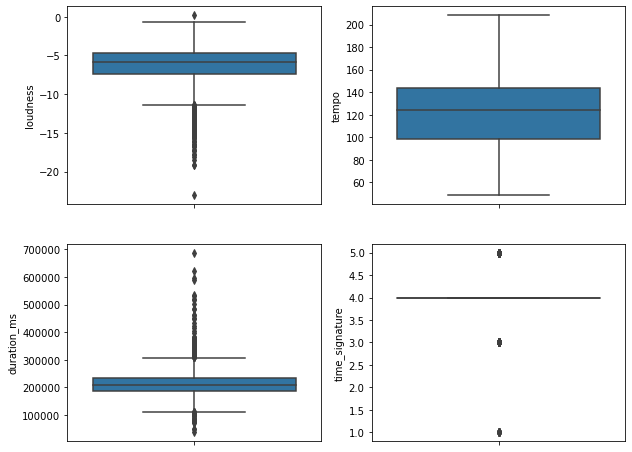

In [13]:
#boxplots for remaining 4 features on independent y axes
f, axes = plt.subplots(2,2,figsize = (10,8))
sns.boxplot(y='loudness', data=songs ,ax=axes[0,0])
sns.boxplot(y='tempo', data=songs, ax=axes[0,1])
sns.boxplot(y='duration_ms', data=songs, ax=axes[1,0])
sns.boxplot(y='time_signature', data=songs, ax=axes[1,1])
plt.show()

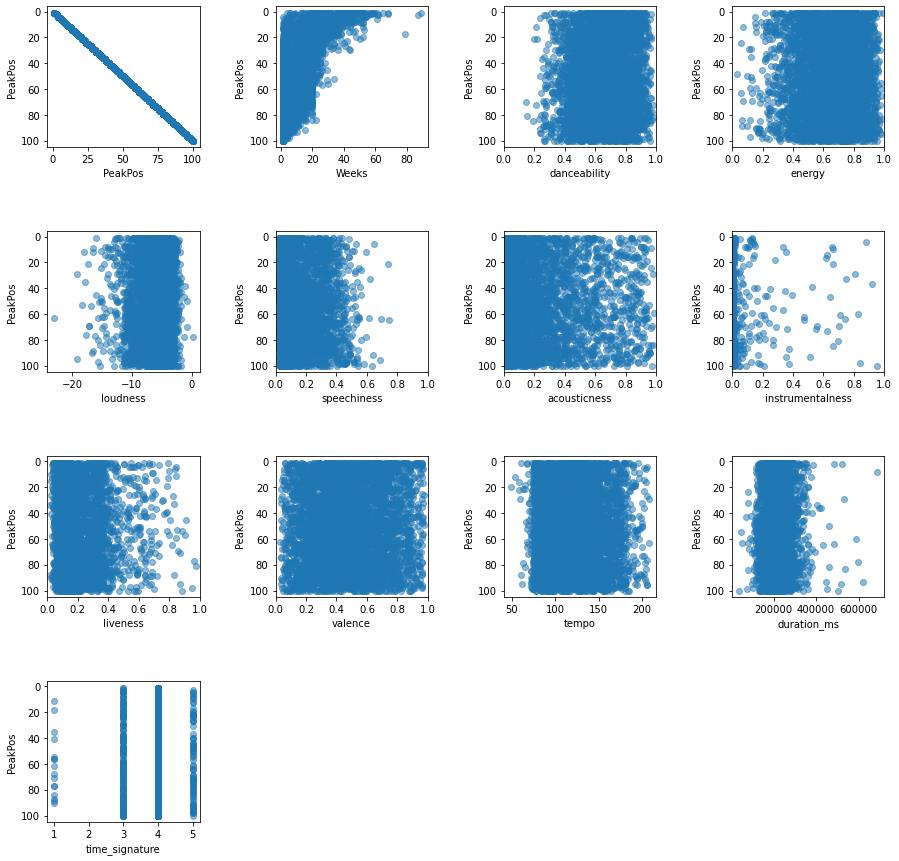

In [14]:
#each unique songs' peakpos plotted against features
scatterplots(features, 'PeakPos', songs, feature_key=zero_to_one_features, invert=True, ncol=4, figsize=(15, 15))

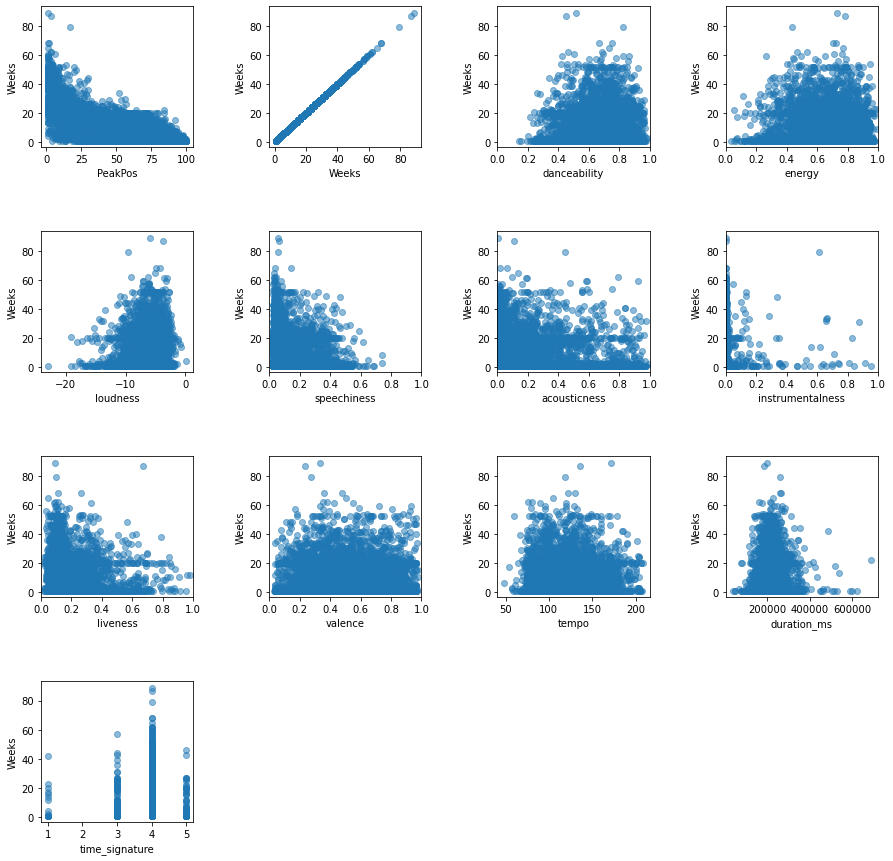

In [15]:
#each unique songs longevity plotted against features
scatterplots(features, 'Weeks', songs, feature_key=zero_to_one_features, ncol=4, figsize=(15, 15))

### 3.2 Explore Trends in Key and Genre

In [16]:
#songs['key'].value_counts()

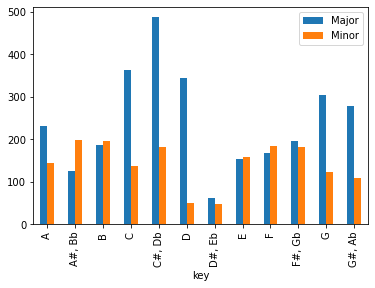

In [17]:
#plot of trends in key and mode
key_group = songs[['mode','key','BB_Title']].groupby(by=['key','mode']).count()

key_group.unstack().plot(kind='bar', stacked=False)
plt.legend(['Major','Minor'])
plt.show()

In [18]:
all_genres = [str(item) for item in songs['Genres'].to_list()]

genre_list = []

for item in all_genres:
    genre_list.extend(item.split(','))

Counter(genre_list).most_common()

[('pop', 1661),
 ('rap', 1540),
 ('dance pop', 1064),
 ('trap', 973),
 ('hip hop', 955),
 ('pop rap', 938),
 ('contemporary country', 694),
 ('country', 603),
 ('country road', 546),
 ('southern hip hop', 535),
 ('post-teen pop', 438),
 ('atl hip hop', 360),
 ('melodic rap', 318),
 ('canadian pop', 284),
 ('r&b', 283),
 ('modern country rock', 274),
 ('urban contemporary', 178),
 ('electropop', 172),
 ('edm', 165),
 ('gangster rap', 160),
 ('canadian hip hop', 157),
 ('toronto rap', 157),
 ('pop rock', 150),
 ('chicago rap', 136),
 ('pop dance', 129),
 ('latin', 129),
 ('country pop', 124),
 ('modern rock', 124),
 ('miami hip hop', 113),
 ('hip pop', 112),
 ('conscious hip hop', 103),
 ('uk pop', 97),
 ('philly rap', 90),
 ('tropical house', 89),
 ('pop r&b', 82),
 ('rock', 82),
 ('reggaeton', 80),
 ('trap latino', 80),
 ('atl trap', 73),
 ('country dawn', 73),
 ('detroit hip hop', 72),
 ('neo mellow', 72),
 ('viral pop', 70),
 ('hollywood', 69),
 ('north carolina hip hop', 65),
 ('tal

In [19]:
#parsing out the genres category into their own rows
genres = songs[['BB_Title','BB_Artist','Genres']]

genres.Genres = genres.Genres.str.split(',')
genres = genres.explode('Genres')

genres.reset_index(drop=True, inplace=True)

genres.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,BB_Title,BB_Artist,Genres
0,Stay,The Kid LAROI & Justin Bieber,australian hip hop
1,Bad Habits,Ed Sheeran,pop
2,Bad Habits,Ed Sheeran,uk pop
3,Good 4 U,Olivia Rodrigo,pop
4,Rumors,Lizzo Featuring Cardi B,dance pop


In [20]:
#genres column split into individual columns for each genres using get_dummies()
genre_dummies = pd.concat([genres, pd.get_dummies(data=genres.Genres)],axis=1)\
                .groupby(by=['BB_Title','BB_Artist'],as_index=False).sum()

genre_dummies

,BB_Title,BB_Artist,a cappella,acoustic pop,adult standards,afro dancehall,afrofuturism,afropop,afroswing,alabama indie,...,virgin islands reggae,virginia hip hop,vocal house,vocal jazz,west coast rap,west coast trap,world worship,worship,yacht rock,yodeling
0,#Beautiful,Mariah Carey Featuring Miguel,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#SELFIE,The Chainsmokers,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,#thatPOWER,will.i.am Featuring Justin Bieber,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,'Tis The Damn Season,Taylor Swift,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4604,idontwannabeyouanymore,Billie Eilish,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4605,ily,Surf Mesa Featuring Emilee,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4606,m.A.A.d City,Kendrick Lamar Featuring MC Eiht,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4607,pov,Ariana Grande,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Focus on PeakPos on Billboard Charts

In [21]:
#isolating peakpos by groups of 5
peak_pos = songs.groupby(pd.cut(songs["PeakPos"], np.arange(0, 101, 5))).mean()

#peak_pos

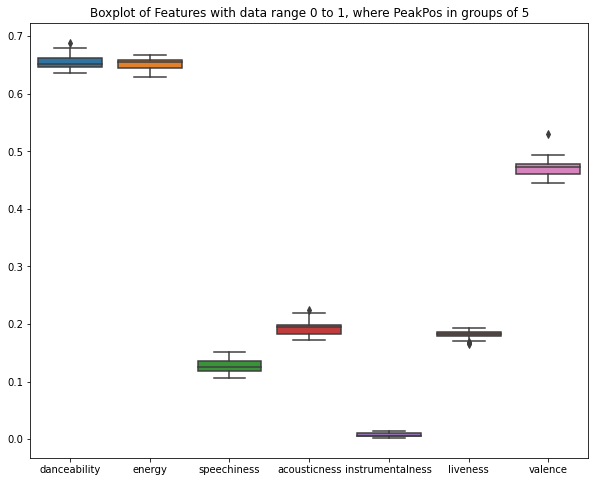

In [22]:
plt.subplots(figsize=(10,8))
sns.boxplot(data=peak_pos[zero_to_one_features])
plt.title('Boxplot of Features with data range 0 to 1, where PeakPos in groups of 5')
plt.show()

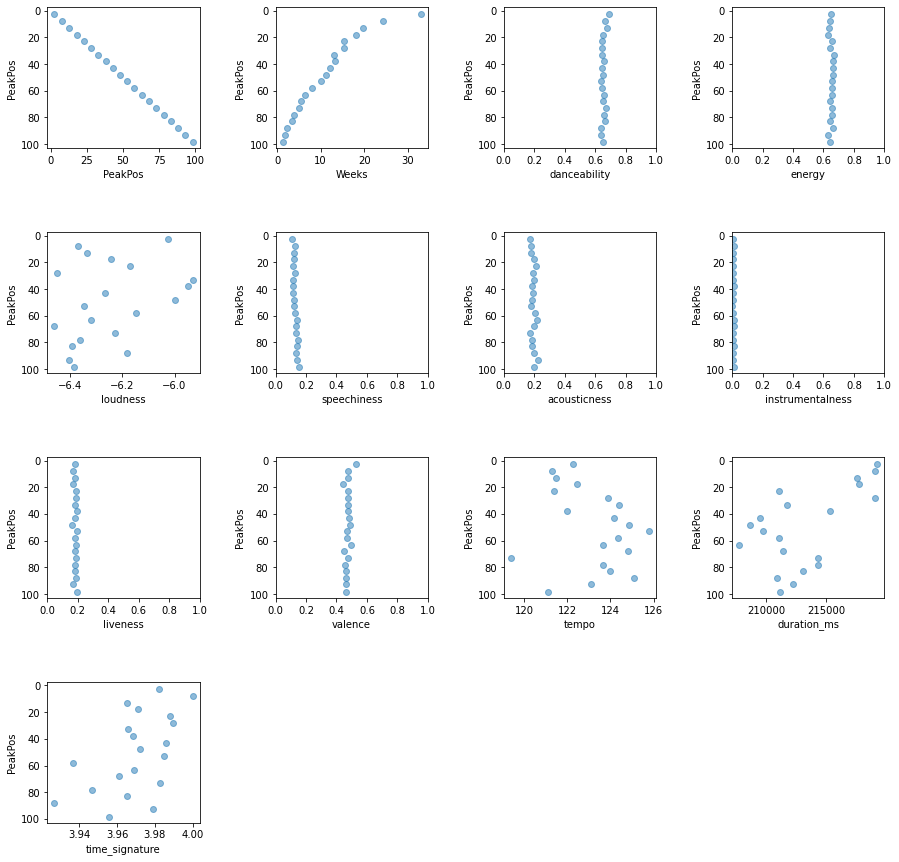

In [23]:
#each peakpos grouping plotted against features
scatterplots(features, 'PeakPos', peak_pos, feature_key=zero_to_one_features, invert=True, ncol=4, figsize=(15, 15))

In [24]:
#scale peakpos from -1 to 1
peak_pos_scale = peak_pos.drop(columns=['PeakPos','Weeks'])
peak_pos_scale_index = peak_pos_scale.index
peak_pos_scale_columns = peak_pos_scale.columns

In [25]:
peak_pos_scale = scale(peak_pos_scale)

peak_pos_scaled_df = pd.DataFrame(peak_pos_scale, columns=peak_pos_scale_columns)
peak_pos_scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2.448944,0.120040,1.373044,-1.771437,-1.538302,-0.514743,0.031505,3.210851,-0.539654,1.694657,0.684500
1,0.803929,-0.534916,-0.751462,-0.040532,-1.082448,1.263252,-1.485189,0.156565,-1.140380,1.632010,1.688543
2,1.817353,-1.645529,-0.546610,-0.354368,-0.827653,-0.614172,0.368096,0.283912,-1.042719,1.209947,-0.261338
3,-0.135582,-2.050563,0.023393,-0.664834,0.358513,-0.419293,-1.504672,-1.645162,-0.440324,1.256621,0.079192
4,-0.562235,0.545041,0.475325,-1.266684,1.137546,-0.638812,0.466053,0.306660,-1.105901,-0.608085,1.025122


In [26]:
peak_pos_pca = PCA().fit(peak_pos_scale)

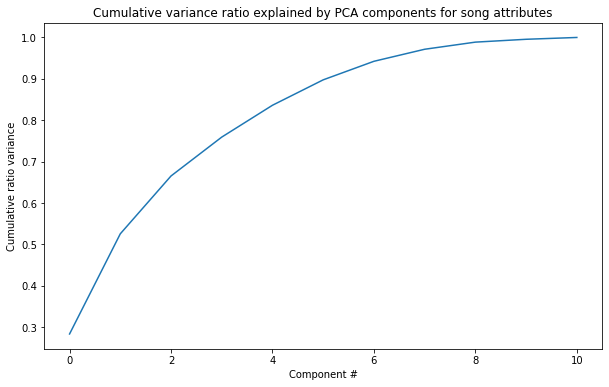

In [27]:
#identify cumulative variance ratio, components and their contribution to variance
plt.subplots(figsize=(10, 6))
plt.plot(peak_pos_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [28]:
peak_pos_pca_x = peak_pos_pca.transform(peak_pos_scale)
peak_pos_pca_x.shape

(20, 11)

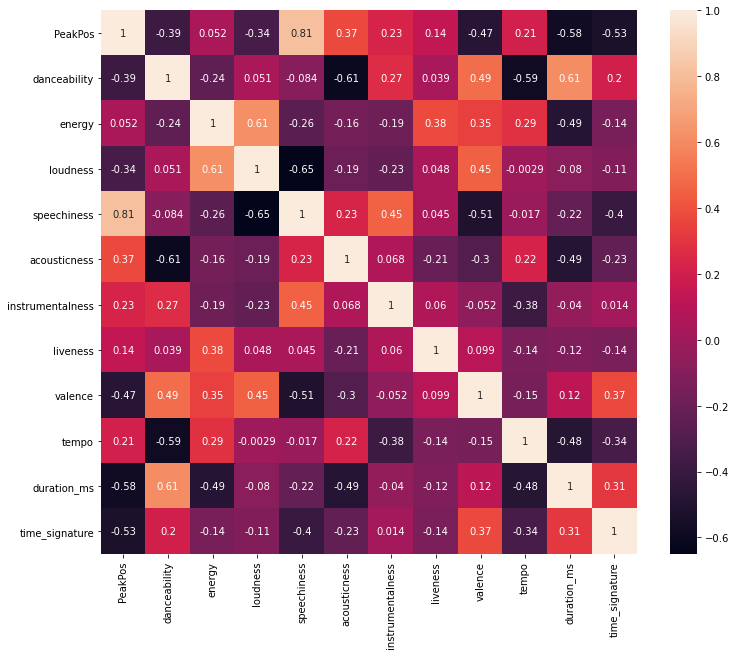

In [29]:
#plot heatmap to show which of the components in the above chart have the highest impact
plt.subplots(figsize=(12,10))
corr_peak_pos = peak_pos.drop(columns='Weeks').corr()
sns.heatmap(corr_peak_pos,annot=True)
plt.show()

In [30]:
#Correlation with output variable
cor_target = abs(corr_peak_pos["PeakPos"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4].sort_values(ascending=False)
relevant_features

PeakPos           1.000000
speechiness       0.810985
duration_ms       0.576695
time_signature    0.533133
valence           0.473513
Name: PeakPos, dtype: float64

In [31]:
#remove valence, relatively high correlation to speechiness
print(peak_pos[["speechiness","valence"]].corr())

             speechiness   valence
speechiness     1.000000 -0.512254
valence        -0.512254  1.000000


### 3.4 Focus on Longevity on Billboard Chart by Weeks

In [32]:
#isolating weeks by groups of 5
weeks = songs.groupby(pd.cut(songs["Weeks"], np.arange(0, 101, 5))).mean()

#weeks

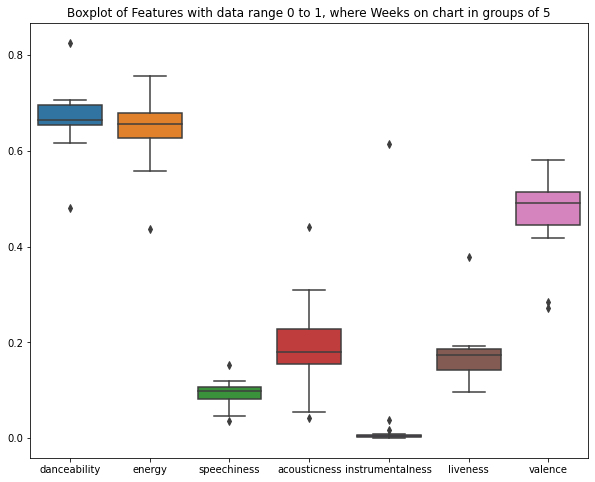

In [33]:
plt.subplots(figsize=(10,8))
sns.boxplot(data=weeks[zero_to_one_features])
plt.title('Boxplot of Features with data range 0 to 1, where Weeks on chart in groups of 5')
plt.show()

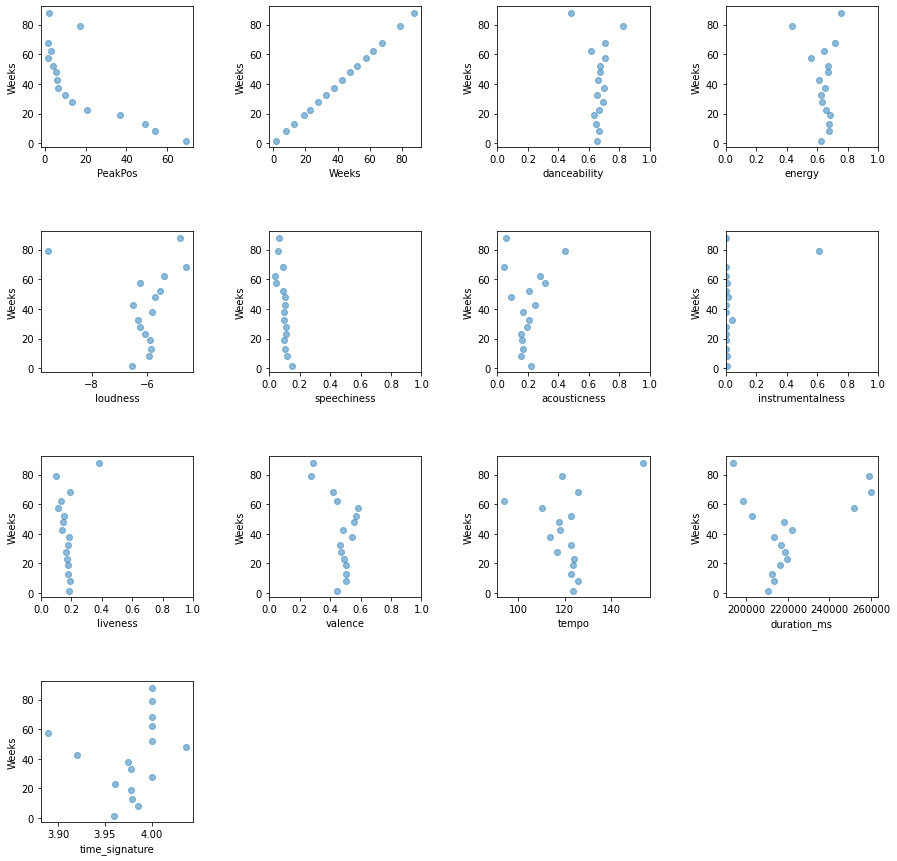

In [34]:
#each weeks grouping plotted against features
scatterplots(features, 'Weeks', weeks, feature_key=zero_to_one_features, ncol=4, figsize=(15, 15))

In [35]:
#songs[songs.Weeks >= 55].sort_values(by='Weeks',ascending = False)

In [36]:
weeks = weeks.dropna()
weeks_scale = weeks.drop(columns=['PeakPos','Weeks'])
weeks_scale_index = weeks_scale.index
weeks_scale_columns = weeks_scale.columns

weeks_scale = scale(weeks_scale)

weeks_scaled_df = pd.DataFrame(weeks_scale, columns=weeks_scale_columns)
weeks_scaled_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.148739,-0.233416,-0.463227,2.109469,0.297240,-0.238139,0.217072,-0.304633,0.234393,-0.510313,-0.568914
1,-0.023010,0.502801,0.131061,0.964701,-0.429206,-0.263656,0.311632,0.370135,0.409802,-0.366675,0.196697
2,-0.246550,0.502556,0.212068,0.506757,-0.270502,-0.273266,0.028786,0.384368,0.160596,-0.412754,0.005319
3,-0.450215,0.607404,0.164131,0.271401,-0.369186,-0.277762,0.101547,0.371416,0.252856,-0.218326,-0.034761
4,-0.037016,0.219305,-0.022127,0.609649,-0.381406,-0.294813,-0.024554,0.263248,0.271017,-0.050034,-0.519714


In [37]:
weeks_pca = PCA().fit(weeks_scale)

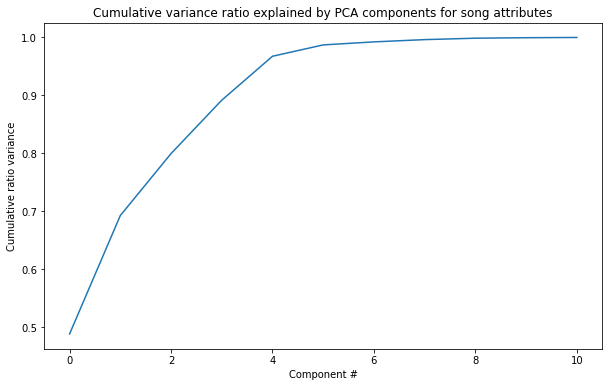

In [38]:
#identify cumulative variance ratio, components and their contribution to variance
plt.subplots(figsize=(10, 6))
plt.plot(weeks_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for song attributes');

In [39]:
weeks_pca_x = weeks_pca.transform(weeks_scale)
weeks_pca_x.shape

(16, 11)

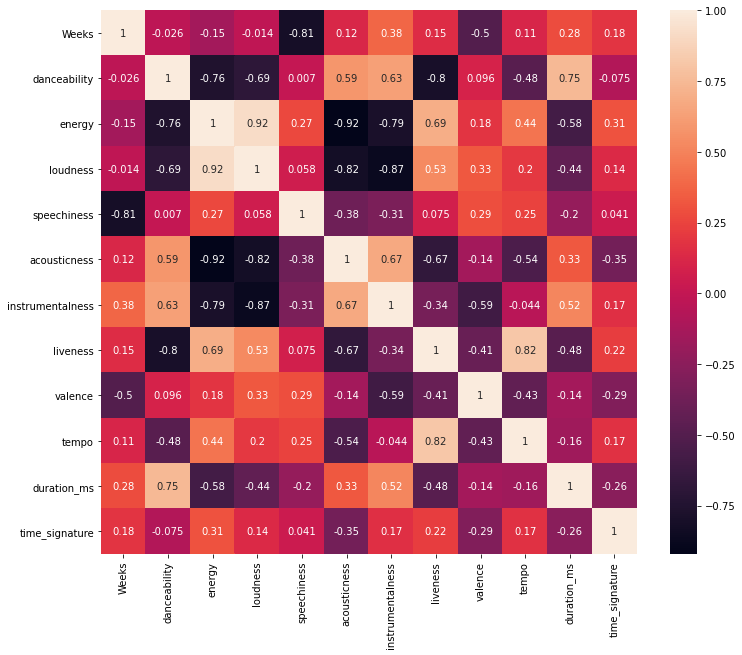

In [40]:
#plot heatmap to show which of the components in the above chart have the highest impact
plt.subplots(figsize=(12,10))
corr_weeks = weeks.drop(columns='PeakPos').corr()
sns.heatmap(corr_weeks,annot=True)
plt.show()

In [41]:
#Correlation with output variable
cor_target = abs(corr_weeks["Weeks"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4].sort_values(ascending=False)
relevant_features

Weeks          1.000000
speechiness    0.811425
valence        0.504863
Name: Weeks, dtype: float64

### 3.5 Focus on "Most Successful" Songs

In [42]:
popular = songs[(songs.Weeks >= 4) & (songs.PeakPos <= 10)]

popular_by_year = popular.groupby(by=popular['Date'].dt.year).mean()

popular_by_year[features]

,PeakPos,Weeks,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
Date,,,,,,,,,,,,,
2011,5.307692,24.076923,0.648385,0.727615,-5.703615,0.076946,0.095089,0.001570,0.240231,0.558923,121.213538,240286.230769,4.000000
2012,4.415094,32.018868,0.650792,0.725491,-5.773736,0.097542,0.122011,0.005616,0.197681,0.567202,123.533528,230540.169811,4.000000
2013,4.703704,31.518519,0.651278,0.699685,-5.681593,0.071348,0.139397,0.013303,0.151620,0.548794,113.052852,231317.203704,4.000000
2014,4.295455,34.500000,0.647886,0.675818,-5.570795,0.083089,0.144972,0.003842,0.183836,0.505341,117.495773,245020.068182,4.000000
2015,5.024390,33.048780,0.666317,0.652512,-5.773341,0.090229,0.197823,0.002696,0.174946,0.531854,126.690220,220444.219512,4.000000
2016,4.396552,32.172414,0.675414,0.663379,-6.366914,0.106828,0.134398,0.004040,0.205822,0.525795,120.965776,224179.000000,3.982759
2017,4.897959,29.979592,0.696939,0.633490,-6.464388,0.138892,0.151228,0.002327,0.138749,0.464061,119.910796,230660.877551,3.979592
2018,4.703125,27.921875,0.734516,0.639703,-5.966625,0.149413,0.123353,0.002734,0.158030,0.466948,122.549406,221648.406250,4.000000
2019,4.297297,34.594595,0.720243,0.623811,-6.030351,0.152424,0.210001,0.009307,0.163900,0.471216,117.623486,201656.135135,4.000000


In [43]:
other = songs[~songs.SP_id.isin(popular.SP_id)]

other_by_year = other.groupby(by=other['Date'].dt.year).mean()

other_by_year[features]

,PeakPos,Weeks,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
Date,,,,,,,,,,,,,
2011,61.764706,8.193277,0.573261,0.728840,-5.418672,0.082653,0.170648,0.001124,0.222271,0.494108,128.212504,220940.882353,3.991597
2012,57.200669,10.983278,0.598278,0.734559,-5.447077,0.086012,0.148907,0.010644,0.195356,0.504690,124.329793,229704.076923,3.983278
2013,58.006349,11.123810,0.598251,0.694641,-5.864251,0.096665,0.150239,0.005437,0.195863,0.493800,126.839200,236476.644444,3.968254
2014,53.896667,12.196667,0.619900,0.692347,-5.883573,0.082171,0.174900,0.011214,0.179227,0.495418,124.343287,226014.526667,3.966667
2015,60.883582,10.447761,0.625734,0.666299,-6.192245,0.102273,0.177316,0.006231,0.185903,0.461286,122.136385,223507.797015,3.889552
2016,55.532951,10.842407,0.630298,0.647947,-6.373218,0.115893,0.182366,0.006093,0.192417,0.445249,120.362504,224593.633238,3.959885
2017,60.147287,8.498708,0.675693,0.621611,-6.585406,0.148752,0.204807,0.008058,0.172151,0.443917,123.403571,215613.105943,3.989664
2018,55.975855,7.277666,0.690875,0.627460,-6.309410,0.161062,0.191219,0.003940,0.175613,0.439579,123.473563,207588.255533,3.983903
2019,58.462222,7.862222,0.678336,0.625382,-6.325007,0.147243,0.228342,0.011664,0.175910,0.460306,122.119244,200511.488889,3.980000


In [44]:
popular_genres = [str(item) for item in popular['Genres'].to_list()]

#Counter(popular_genres).most_common()

In [45]:
other_genres = [str(item) for item in other['Genres'].to_list()]

#Counter(other_genres).most_common()

## 4.0 Summary

1. Cleaned the Unique Song data to remove any incorrect matches or missing SP_ids
2. Explored Billboard Chart data trends on target features (PeakPos & Weeks) across the years
3. Explored Unique Song data with respect to song attributes, treating each song individually
4. Created dummies for genre classifications for further review in next step
5. Explored PeakPos in unique song data in groups of 5 (ie Top 5, 5-10 etc.)
6. Explored Weeks in unique song data in groups of 5
7. Features of interest in next step - Speechiness, Valence, Duration_ms, Time Signature
8. Caution will be taken given high correlation between speechiness & valence


FOR DISCUSSION - Because there is lots of variance in the unique songs scatter plot, and far less in the grouped ones, is it fair to start thinking that the positioning or longevity on the charts isn't highly impacted by the song attribute features?
ie Sail - AWOLNATION

In [46]:
#Export unique song data to csv.
#cwd = os.getcwd()

#songs.to_csv(cws + "/songs_eda")
#peak_pos.to_csv(cwd + "/peak_pos_eda")
#weeks.to_csv(cwd + "/weeks_eda")
#genres.to_csv(cwd + "/genres_eda")
